In [27]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [28]:
ξ_w=100000.
# ξ_w = .3
ξ_p = 5.
ξ_a = 1./100
# ξ_a = 100000.

# ξ_w=100000.
# ξ_p=100000.
# ξ_a=100000.

damage_setting={'γ_2p': np.array([0, .0394, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# damage_setting={'γ_2p': np.array([0, .0394*2, .3853*2]),
#                 'πd_o': np.array([1./3, 1./3, 1./3])}

# Solve for value function, baseline case
model_i_baseline, model_baseline = solve_value_function(100_000., 100_000., 100_000., damage_setting)
# Sovle for value function, distorted case
model_i, model = solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting)

n_damage = len(damage_setting['πd_o'])
y_bar = model['y_grid'][-1]
y_grid_short = model['y_grid']
y_grid_long = model_i[0]['y_grid']

# Simulation
et, yt, ht, gt = simulation(model['y_grid'], model['e_tilde'], model['h'], model['g'],
                            θ=np.mean(model['θ']), y_start=np.mean(model['θ'])*290, T=100)
et_baseline, yt_baseline, _, _ \
               = simulation(model_baseline['y_grid'], model_baseline['e_tilde'],
                            model_baseline['h'], model_baseline['g'],
                            θ=np.mean(model['θ']), y_start=np.mean(model['θ'])*290, T=100)
yt_i = []
ht_i = []
for i in range(n_damage):
    _, y_temp, h_temp, _ = simulation(y_grid_long, model_i[i]['e_tilde'], model_i[i]['h'],
                               np.zeros_like(model_i[0]['e_tilde']).reshape(1, -1), θ=np.mean(model['θ']),
                               y_start=np.mean(model['θ'])*290, T=100)
    yt_i.append(y_temp)
    ht_i.append(h_temp)

Converged. Total iteration 5000: LHS Error: 0.00011794573695667054; RHS Error 6.681372455581702e-05
Converged. Total iteration 1501: LHS Error: 9.932937805601227e-09; RHS Error 0.0004825812927628306
Converged. Total iteration 1619: LHS Error: 9.868386996458867e-09; RHS Error 0.0022617539616424306
Converged. Total iteration 372: LHS Error: 8.939528228779636e-09; RHS Error 0.0006258279853032234
Converged. Total iteration 5000: LHS Error: 4.183515303690655e-05; RHS Error 9.117047385512334e-05
Converged. Total iteration 1507: LHS Error: 9.965610114903711e-09; RHS Error 0.00047002697355678913
Converged. Total iteration 1621: LHS Error: 9.952280777270062e-09; RHS Error 0.0022788046860334884
Converged. Total iteration 443: LHS Error: 9.764197450579104e-09; RHS Error 0.0008703168687622803


In [3]:
# np.save('e_star', model['e_tilde'])

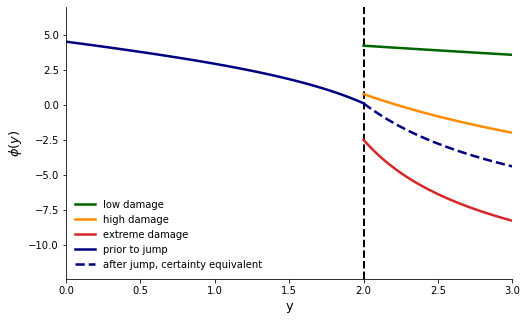

In [14]:
# 1. Plot value function
temp = np.array([res['v0'] for res in model_i])
certainty_equivalent = -ξ_p*np.log(np.average(np.exp(-1./ξ_p*temp), axis=0, weights=damage_setting['πd_o']))

plt.figure(figsize=(8, 5))
plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[0]['v0'][y_grid_long>=y_bar],
         color='darkgreen', linewidth=2.5, label='low damage')
plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[1]['v0'][y_grid_long>=y_bar],
         color='darkorange', linewidth=2.5, label='high damage')
if n_damage == 3:
    plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[2]['v0'][y_grid_long>=y_bar],
             color='tab:red', linewidth=2.5, label='extreme damage')
plt.plot(y_grid_short, model['v0'], color='navy', linewidth=2.5, label='prior to jump')
plt.plot(y_grid_long[y_grid_long>=y_bar], certainty_equivalent[y_grid_long>=y_bar],
         color='navy', linewidth=2.5, linestyle='dashed', label='after jump, certainty equivalent')
y_min = np.min(model_i[2]['v0'])*1.2
y_max = np.max(model_i[0]['v0'])*1.2
plt.vlines(2., ymin=y_min, ymax=y_max, color='black', linestyle='dashed', linewidth=2.)
plt.xlim(0, 3.)
plt.ylim(y_min, y_max)
plt.legend(frameon=False)
plt.xlabel('y', fontsize=13)
plt.ylabel(r'$\phi(y)$', fontsize=13)
plt.savefig('../plots/standardized/value_function.pdf')

(0.0, 2.1)

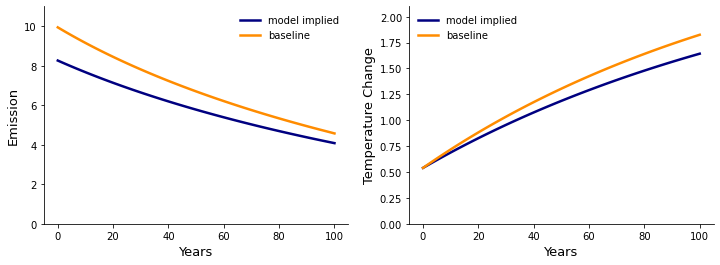

In [15]:
# 2. Plot emission and temperature change
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(et, color='navy', label='model implied', linewidth=2.5)
ax1.plot(et_baseline, color='darkorange', label=r'baseline', linewidth=2.5)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('Emission', fontsize=13)
ax1.legend(frameon=False)
ax1.set_ylim(0., int(np.max(et_baseline)*1.2))

ax2.plot(yt, color='navy', label='model implied', linewidth=2.5)
ax2.plot(yt_baseline, color='darkorange', label='baseline', linewidth=2.5)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel('Temperature Change', fontsize=13)
ax2.legend(frameon=False)
ax2.set_ylim(0., int(np.max(yt_baseline*10)*1.2)/10)

# fig.savefig('../plots/standardized/emission_temperature.pdf')

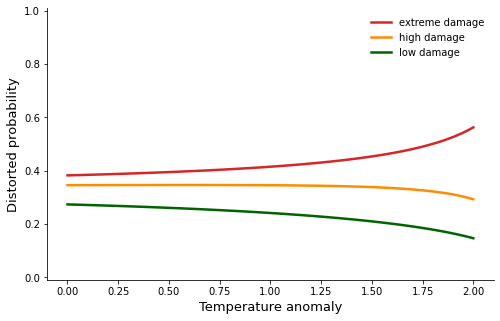

In [16]:
# 3.1 Plot distorted probabilities for damage function, vs y
plt.figure(figsize=(8, 5))
if n_damage == 3:
    plt.plot(y_grid_short, model['g'][2]*damage_setting['πd_o'][2]/np.average(model['g'], weights=damage_setting['πd_o'], axis=0), color='tab:red', label='extreme damage', linewidth=2.5)
plt.plot(y_grid_short, model['g'][1]*damage_setting['πd_o'][1]/np.average(model['g'], weights=damage_setting['πd_o'], axis=0), color='darkorange', label='high damage', linewidth=2.5)
plt.plot(y_grid_short, model['g'][0]*damage_setting['πd_o'][0]/np.average(model['g'], weights=damage_setting['πd_o'], axis=0), color='darkgreen', label='low damage', linewidth=2.5)
plt.xlabel('Temperature anomaly', fontsize=13)
plt.ylabel('Distorted probability', fontsize=13)
plt.ylim(-.01, 1.01)
plt.legend(frameon=False)

# plt.savefig('../plots/standardized/damage_probability.pdf')

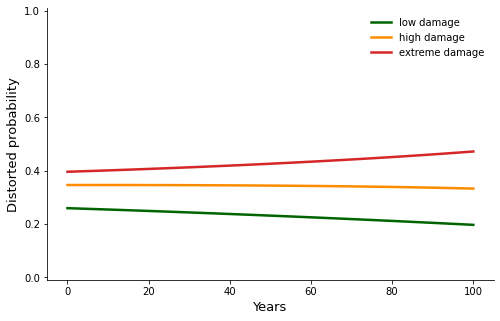

In [17]:
# 3.1 Plot distorted probabilities for damage function
plt.figure(figsize=(8, 5))
plt.plot(gt[0]*damage_setting['πd_o'][0]/np.average(gt, weights=damage_setting['πd_o'], axis=0), color='darkgreen', label='low damage', linewidth=2.5)
plt.plot(gt[1]*damage_setting['πd_o'][1]/np.average(gt, weights=damage_setting['πd_o'], axis=0), color='darkorange', label='high damage', linewidth=2.5)
if n_damage == 3:
    plt.plot(gt[2]*damage_setting['πd_o'][2]/np.average(gt, weights=damage_setting['πd_o'], axis=0), color='tab:red', label='extreme damage', linewidth=2.5)
plt.xlabel('Years', fontsize=13)
plt.ylabel('Distorted probability', fontsize=13)
plt.ylim(-.01, 1.01)
plt.legend(frameon=False)

plt.savefig('../plots/standardized/damage_probability.pdf')

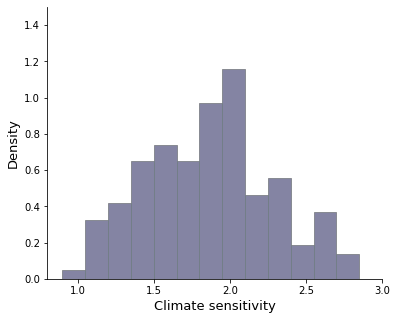

In [18]:
T_mid = 50
loc_mid = find_nearest_value(y_grid_short, yt[T_mid])

plt.figure(figsize=(6, 5))
bins = np.linspace(0., 3., 21)

plt.hist(model['θ']*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
plt.hist((model['θ'])*1000, weights=model['πc'][:, loc_mid], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
plt.xlabel('Climate sensitivity', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.ylim(0,1.5)
plt.xticks(np.arange(0,3+0.5, 0.5))
plt.xlim(.8, 3)

plt.savefig('../plots/standardized/climate_worstcase.pdf')

In [12]:
np.sum(model['πc'][:, loc_mid]*model['θ']*1000) - np.mean(model['θ']*1000)

0.2569894216887256

In [19]:
ht

array([0.1117859 , 0.11178867, 0.11179136, 0.11179399, 0.11179655,
       0.11179903, 0.11180144, 0.11180378, 0.11180607, 0.11180827,
       0.11181041, 0.1118125 , 0.11181452, 0.11181647, 0.11181838,
       0.11182022, 0.111822  , 0.11182373, 0.11182541, 0.11182702,
       0.11182859, 0.11183012, 0.11183157, 0.11183299, 0.11183436,
       0.11183567, 0.11183694, 0.11183817, 0.11183935, 0.11184049,
       0.11184158, 0.11184262, 0.11184364, 0.1118446 , 0.11184552,
       0.11184641, 0.11184725, 0.11184807, 0.11184883, 0.11184957,
       0.11185027, 0.11185093, 0.11185156, 0.11185215, 0.11185272,
       0.11185324, 0.11185374, 0.1118542 , 0.11185463, 0.11185503,
       0.1118554 , 0.11185574, 0.11185605, 0.11185634, 0.11185659,
       0.11185683, 0.11185702, 0.1118572 , 0.11185734, 0.11185747,
       0.11185756, 0.11185764, 0.11185768, 0.11185771, 0.11185771,
       0.11185769, 0.11185764, 0.11185759, 0.11185749, 0.11185739,
       0.11185725, 0.1118571 , 0.11185692, 0.11185674, 0.11185

In [20]:
1.86/1000 * 1.2 * .11185605 * 1000 # .3

0.24966270359999998

In [13]:
ϵ = 5.
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

σ_y = 1.2*np.mean(θ)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_step = .04
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Uncertainty decomposition
n_temp = 16
n_carb = 9
θ_reshape = θ.reshape(n_temp, n_carb)
θ_temp = np.mean(θ_reshape, axis=1)
θ_carb = np.mean(θ_reshape, axis=0)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

# Prepare ϕ_i (carbon + temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (carbon)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb = np.array(ϕ_list_short)

# Prepare ϕ_i (temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (baseline)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, 1000., γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_baseline = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i_carb_temp, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                             v0=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0),
                                             ϵ=ϵ, tol=1e-8, max_iter=5_000, print_all=False)

ME_total = η/model_res['e_tilde']

In [ ]:
# Solve temperature & carbon uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_carb = model_res_new['ME']

# Solve temperature, carbon and damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=None,
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_total_check = model_res_new['ME']

# Solve temperature uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_temp, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp = model_res_new['ME']

# Solve carbon uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=np.average(ϕ_i_carb, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb = model_res_new['ME']

# Solve damage uncertainty
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_damage = model_res_new['ME']

# Solve temperature uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_temp, πc_o_temp, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_temp, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_temp_damage = model_res_new['ME']

# Solve carbon uncertainty + damage uncertainty
model_paras_new = (η, δ, θ_carb, πc_o_carb, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_carb, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=None,
                                          bc=None,
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_carb_damage = model_res_new['ME']


# Solve baseline
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=np.average(ϕ_i_baseline, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_baseline = model_res_new['ME']

In [11]:
def simulation_me(y_grid, e_grid, ratio_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ratio_t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ratio_t[i] = np.interp(y_start, y_grid, ratio_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ratio_t

In [ ]:
plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, temp_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)

# plt.plot(y_grid_short, np.log(ME_total/ME_baseline)*(100), label='total', color='tab:red', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_temp/ME_baseline)*(100), label='temperature uncertainty', color='darkorange', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_carb/ME_baseline)*(100), label='carbon uncertainty', color='darkgreen', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_damage/ME_baseline)*(100), label='damage uncertainty', color='navy', linewidth=2.5)
# plt.xlabel('Temperature anomaly', fontsize=13)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(damage_t, label='damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(temp_t, label='temperature uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(carb_t, label='carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 80)
plt.savefig('../plots/standardized/uncertainty_one_partition.pdf')

In [ ]:
plt.figure(figsize=(8, 5))

_, _, total_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_total/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, temp_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, carb_damage_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_carb_damage/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)
_, _, temp_carb_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      np.log(ME_temp_carb/ME_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)

# plt.plot(y_grid_short, np.log(ME_total/ME_baseline)*(100), label='total', color='tab:red', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_temp_damage/ME_baseline)*(100), label='temperature and damage uncertainty', color='darkorange', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_carb_damage/ME_baseline)*(100), label='carbon and damage uncertainty', color='darkgreen', linewidth=2.5)
# plt.plot(y_grid_short, np.log(ME_temp_carb/ME_baseline)*(100), label='carbon and temperature uncertainty', color='navy', linewidth=2.5)
# plt.xlabel('Temperature anomaly', fontsize=13)

plt.plot(total_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(temp_damage_t, label='temperature and damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(carb_damage_t, label='carbon and damage uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(temp_carb_t, label='carbon and temperature uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper left')
plt.ylim(0, 80)
plt.savefig('../plots/standardized/uncertainty_two_partition.pdf')

In [ ]:
# 5. Plot SCC
et_tilde, yt, ratio_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      ME_baseline/ME_total, θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

SCCt_all = η*(0.025)*Kt/((1.-η)*et_tilde) * 1000
SCCt_baseline = SCCt_all * ratio_t
SCCt_uncertainty = SCCt_all - SCCt_baseline

plt.figure(figsize=(8, 5))
plt.plot(SCCt_all, color='rebeccapurple', label='Total', linewidth=2.5)
plt.plot(SCCt_uncertainty, color='rebeccapurple', label='Uncertainty', linestyle='dashed', linewidth=2.5)
plt.fill_between(np.arange(0, 101, 1), np.zeros_like(SCCt_uncertainty), 
                 SCCt_uncertainty, color='rebeccapurple', alpha=.4)
plt.ylim(0, 1200)
plt.xlim(0, 100)
plt.xlabel('Years', fontsize=13)
plt.ylabel('SCC ($/tC)', fontsize=13)
plt.legend(frameon=False)
plt.savefig('../plots/standardized/scc.pdf')

Evolution of damages:

$$
d \log N_t = \mu_n(Y_t, F_t) dt + \sigma_n(Y_t, F_t) \cdot dW_t
$$

where

$$
\mu_n(y, f) = \left(\gamma_1 + \gamma_2 y\right) \mu_y(f) + \frac{1}{2}\gamma_2|\sigma_y(f)|^2
$$

and

$$
\sigma_n(y, f) = \left(\gamma_1 + \gamma_2 y\right) \sigma_y (f)
$$

where $\mu_y(f) = f \sum_{i=1}^n \pi^a_i \theta_i$ and $\sigma_y(f) =  f\zeta$.

In [ ]:
# Smimulate damages
γ_1 = 1.7675/10000
γ_2 = .0022*2
θ_reshape = np.zeros_like(model['πc'])
for i in range(θ_reshape.shape[0]):
    θ_reshape[i] = model['θ'][i]
mu_y = model['e_tilde'] * np.sum(model['πc']*θ_reshape, axis=0)
sigma_y = model['e_tilde'] * model['σ_y']
mu_n = (γ_1 + γ_2 * model['y_grid']) * mu_y + .5 * γ_2 * sigma_y**2
sigma_n = (γ_1 + γ_2 * model['y_grid']) * sigma_y

In [ ]:
@njit
def simulation_damage(y_grid, e_grid, mu_n_grid, sigma_n_grid, 
                      mu_y_grid, sigma_y_grid, Ws, y_start=.5394):
    n_path, T = Ws.shape
    log_N = np.zeros((n_path, T+1))
    for n in range(n_path):
        y = y_start
        for t in range(1, T+1):
            # Updtea drift and diffusion
            mu_n_t = np.interp(y, y_grid, mu_n_grid)
            sigma_n_t = np.interp(y, y_grid, sigma_n_grid)
            log_N[n, t] = log_N[n, t-1] + mu_n_t + sigma_n_t * Ws[n, t-1]
            # Update y
            e_t = np.interp(y, y_grid, e_grid)
            mu_y_t = np.interp(y, y_grid, mu_y_grid)
            sigma_y_t = np.interp(y, y_grid, sigma_y_grid)
            y = y + mu_y_t + sigma_y_t * Ws[n, t-1]
    return log_N

In [ ]:
T = 100
n_path = 100_000
Ws = np.random.normal(0., 1., (n_path, T))

In [ ]:
log_N = simulation_damage(model['y_grid'], model['e_tilde'], mu_n, sigma_n,
                          mu_y, sigma_y, Ws, y_start=.5394)
N = np.exp(log_N)

In [ ]:
N_10 = np.percentile(N, 10, axis=0)
N_50 = np.percentile(N, 50, axis=0)
N_90 = np.percentile(N, 90, axis=0)

log_N_10 = np.percentile(log_N, 10, axis=0)
log_N_50 = np.percentile(log_N, 50, axis=0)
log_N_90 = np.percentile(log_N, 90, axis=0)

In [ ]:
plt.plot(1/N_10)
plt.plot(1/N_50)
plt.plot(1/N_90)

In [ ]:
plt.plot(log_N_10*100, label='.1 percentile')
plt.plot(log_N_50*100, label='.5 percentile')
plt.plot(log_N_90*100, label='.9 percentile')
plt.xlabel('Years')
plt.title(r'$\log N_t$ * 100')
plt.legend(frameon=False)

In [ ]:
1.86/1000 * 1.2 * .186 * 1000 # 1/600

In [ ]:
1.86/1000 * 1.2 * .132 * 1000 # 1/400

In [ ]:
1.86/1000 * 1.2 * .12 * 1000 # 1/360

In [ ]:
1.86/1000 * 1.2 * .117 * 1000 # 1/350

In [ ]:
1.86/1000 * 1.2 * .114 * 1000 # 1/340

In [ ]:
0.11178887
1.86/1000 * 1.2 * .1118 * 1000 # 1/300

### Compare one state model and two state models

In [ ]:
from scipy.interpolate import interp2d

emission_grid_two_state = np.load('emission_two_state.npy')
emission_grid_two_state_low = np.load('emission_two_state_low.npy')
emission_grid_two_state_high = np.load('emission_two_state_high.npy')
emission_grid_two_state_extreme = np.load('emission_two_state_extreme.npy')


y1_grid = np.arange(0., 2.+.04, .04)
y2_grid = np.arange(0., .05, .001)
y1_grid_long = np.arange(0., 4., .04)

def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = y2_0 - λ*y2_0 + λ*θ*Et[i] 
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

et_two_state, y1t, y2t = simulation(y1_grid, y2_grid, emission_grid_two_state, .116,
                          θ=np.mean(model['θ']), y1_0=.5394, y2_0=np.mean(model['θ']), T=100)
et_two_state_low, y1t, y2t = simulation(y1_grid_long, y2_grid, emission_grid_two_state_low, .116,
                          θ=np.mean(model['θ']), y1_0=.5394, y2_0=np.mean(model['θ']), T=100)
et_two_state_high, y1t, y2t = simulation(y1_grid_long, y2_grid, emission_grid_two_state_high, .116,
                          θ=np.mean(model['θ']), y1_0=.5394, y2_0=np.mean(model['θ']), T=100)
et_two_state_extreme, y1t, y2t = simulation(y1_grid_long, y2_grid, emission_grid_two_state_extreme, .116,
                          θ=np.mean(model['θ']), y1_0=.5394, y2_0=np.mean(model['θ']), T=100)

In [ ]:
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [ ]:
SCCt_one_state = η*(0.025)*Kt/((1.-η)*et) * 1000 # .025 is alpha - i/k
SCCt_two_state = η*(0.025)*Kt/((1.-η)*et_two_state) * 1000 # .025 is alpha - i/k

In [ ]:
plt.plot(SCCt_one_state, label='Y has one state')
plt.plot(SCCt_two_state, label='Y has two states')
plt.xlabel('Years')
plt.ylim(0, 1100)
plt.legend(frameon=False)
plt.title('SCC')

In [ ]:
plt.plot(et, label='Y has one state')
plt.plot(et_two_state, label='Y has two states')
plt.legend(frameon=False)
plt.ylim(0, 11)
plt.xlabel('Years')
plt.title('Emission trajectory')

### Compare to smooth ambiguity over damage

In [29]:
from scipy.interpolate import interp2d

emission_grid_damage_ambiguity = np.load('emission_damage_ambiguity.npy')

y_grid_new = np.arange(0., 4.+.02, .02)

et_damage_ambiguity, yt, _, _ = simulation(y_grid_new, emission_grid_damage_ambiguity,
                                           np.zeros_like(y_grid_new),
                                           np.zeros((3, len(y_grid_new))),
                                           θ=np.mean(model['θ']), y_start=np.mean(model['θ'])*290, T=100)

In [30]:
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

Text(0.5, 0, 'Years')

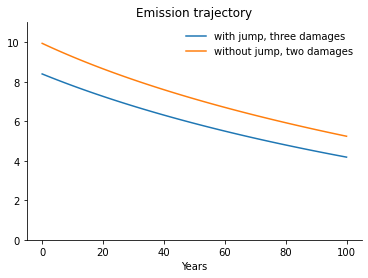

In [31]:
plt.plot(et, label='with jump, three damages')
plt.plot(et_damage_ambiguity, label='without jump, two damages')
plt.legend(frameon=False)
plt.ylim(0, 11)
plt.title('Emission trajectory')
plt.xlabel('Years')

In [32]:
SCCt = η*(0.025)*Kt/((1.-η)*et) * 1000 # .025 is alpha - i/k
SCCt_damage_ambiguity = η*(0.025)*Kt/((1.-η)*et_damage_ambiguity) * 1000 # .025 is alpha - i/k

Text(0.5, 0, 'Years')

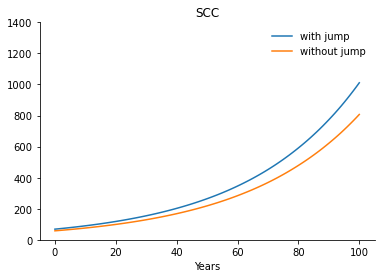

In [33]:
plt.plot(SCCt, label='with jump')
plt.plot(SCCt_damage_ambiguity, label='without jump')
plt.legend(frameon=False)
plt.ylim(0, 1400)
plt.title('SCC')
plt.xlabel('Years')

### Uncertainty decomposition for damage with smooth ambiguity

(0.0, 35.0)

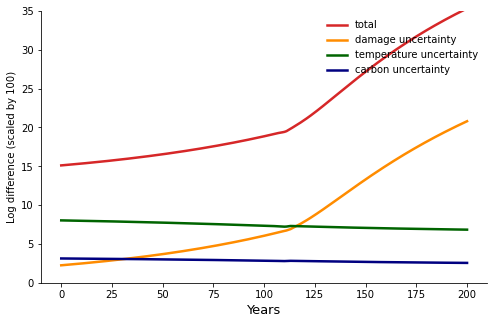

In [36]:
y_grid_temp = np.arange(0., 4.+.02, .02)

ME_new_baseline = np.load('ME_baseline_damage_ambiguity.npy')
ME_new_damage = np.load('ME_damage_damage_ambiguity.npy')
ME_new_temp = np.load('ME_temp_damage_ambiguity.npy')
ME_new_carb = np.load('ME_carb_damage_ambiguity.npy')
ME_new_damage_temp = np.load('ME_damage_temp_damage_ambiguity.npy')
ME_new_damage_carb = np.load('ME_damage_carb_damage_ambiguity.npy')
ME_new_temp_carb = np.load('ME_temp_carb_damage_ambiguity.npy')
ME_new_total = np.load('ME_damage_ambiguity.npy')

plt.figure(figsize=(8, 5))

_, _, total_new_t = simulation_me(y_grid_temp, emission_grid_damage_ambiguity, 
                                      np.log(ME_new_total/ME_new_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=200)
_, _, temp_new_t = simulation_me(y_grid_temp, emission_grid_damage_ambiguity, 
                                      np.log(ME_new_temp/ME_new_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=200)
_, _, carb_new_t = simulation_me(y_grid_temp, emission_grid_damage_ambiguity, 
                                      np.log(ME_new_carb/ME_new_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=200)
_, _, damage_new_t = simulation_me(y_grid_temp, emission_grid_damage_ambiguity, 
                                      np.log(ME_new_damage/ME_new_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=200)

plt.plot(total_new_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(damage_new_t, label='damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(temp_new_t, label='temperature uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(carb_new_t, label='carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper right')
plt.ylim(0, 35)
# plt.savefig('../plots/standardized/uncertainty_one_partition.pdf')

(0.0, 35.0)

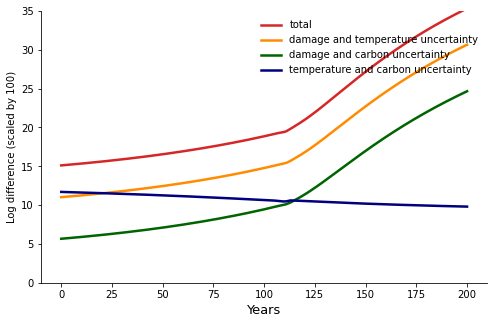

In [37]:
plt.figure(figsize=(8, 5))

_, _, damage_temp_new_t = simulation_me(y_grid_temp, emission_grid_damage_ambiguity, 
                                      np.log(ME_new_damage_temp/ME_new_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=200)
_, _, damage_carb_new_t = simulation_me(y_grid_temp, emission_grid_damage_ambiguity, 
                                      np.log(ME_new_damage_carb/ME_new_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=200)
_, _, temp_carb_new_t = simulation_me(y_grid_temp, emission_grid_damage_ambiguity, 
                                      np.log(ME_new_temp_carb/ME_new_baseline)*(100), θ=np.mean(θ), y_start=np.mean(θ)*290, T=200)

plt.plot(total_new_t, label='total', color='tab:red', linewidth=2.5)
plt.plot(damage_temp_new_t, label='damage and temperature uncertainty', color='darkorange', linewidth=2.5)
plt.plot(damage_carb_new_t, label='damage and carbon uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(temp_carb_new_t, label='temperature and carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('Years', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper right')
plt.ylim(0, 35)
# plt.savefig('../plots/standardized/uncertainty_two_partition.pdf')

(0.0, 250.0)

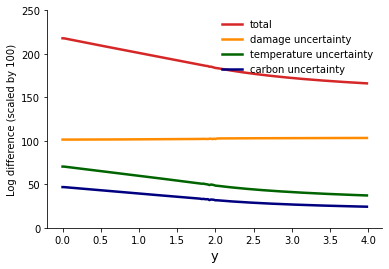

In [72]:
plt.plot(y_grid_temp, np.log(ME_new_total/ME_new_baseline)*100, label='total', color='tab:red', linewidth=2.5)
plt.plot(y_grid_temp, np.log(ME_new_damage/ME_new_baseline)*100, label='damage uncertainty', color='darkorange', linewidth=2.5)
plt.plot(y_grid_temp, np.log(ME_new_temp/ME_new_baseline)*100, label='temperature uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(y_grid_temp, np.log(ME_new_carb/ME_new_baseline)*100, label='carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('y', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper right')
plt.ylim(0, 250)

(0.0, 250.0)

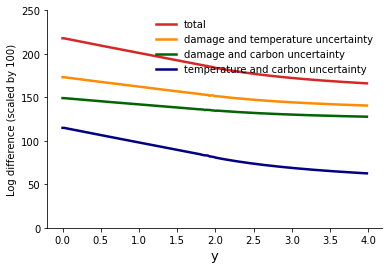

In [73]:
plt.plot(y_grid_temp, np.log(ME_new_total/ME_new_baseline)*100, label='total', color='tab:red', linewidth=2.5)
plt.plot(y_grid_temp, np.log(ME_new_damage_temp/ME_new_baseline)*100, label='damage and temperature uncertainty', color='darkorange', linewidth=2.5)
plt.plot(y_grid_temp, np.log(ME_new_damage_carb/ME_new_baseline)*100, label='damage and carbon uncertainty', color='darkgreen', linewidth=2.5)
plt.plot(y_grid_temp, np.log(ME_new_temp_carb/ME_new_baseline)*100, label='temperature and carbon uncertainty', color='navy', linewidth=2.5)
plt.xlabel('y', fontsize=13)

plt.ylabel(r'Log difference (scaled by 100)')
plt.legend(frameon=False, loc='upper right')
plt.ylim(0, 250)